<a href="https://colab.research.google.com/github/amazingashis/Machine_Learning_Advanced/blob/main/Tensor_Flow_Low_Level_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Introduction to Variables**
A TensorFlow variable is the recommended way to represent shared, persistent state your program manipulates. This guide covers how to create, update, and manage instances of tf.Variable in TensorFlow.

Variables are created and tracked via the tf.Variable class. A tf.Variable represents a tensor whose value can be changed by running ops on it. Specific ops allow you to read and modify the values of this tensor. Higher level libraries like tf.keras use tf.Variable to store model parameters.

In [1]:
import tensorflow as tf


In [2]:
my_tensor = tf.constant(5)
my_variable = tf.Variable([[4,6],[5,6]])

# Variables can be all kinds of types, just like tensors
bool_variable = tf.Variable([False, False, False, True])
complex_variable = tf.Variable([5 + 4j, 6 + 1j])

A variable looks and acts like a tensor, and, in fact, is a data structure backed by a tf.Tensor. Like tensors, they have a dtype and a shape, and can be exported to NumPy.

In [6]:
print("Shape:",my_variable.shape)
print("Dtype",my_variable.dtype)
print("As Numpy:",my_variable.numpy)

Shape: (2, 2)
Dtype <dtype: 'int32'>
As Numpy: <bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[4, 6],
       [5, 6]], dtype=int32)>>



Most tensor operations work on variables as expected, although variables cannot be reshaped.

In [7]:
print("A variable:",my_variable)
print("\nViewed as a tensor:", tf.convert_to_tensor(my_variable))
print("\nIndex of highest value:", tf.argmax(my_variable))

# This creates a new tensor; it does not reshape the variable.
print("\nCopying and reshaping: ", tf.reshape(my_variable, ([1,4])))


A variable: <tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[4, 6],
       [5, 6]], dtype=int32)>

Viewed as a tensor: tf.Tensor(
[[4 6]
 [5 6]], shape=(2, 2), dtype=int32)

Index of highest value: tf.Tensor([1 0], shape=(2,), dtype=int64)

Copying and reshaping:  tf.Tensor([[4 6 5 6]], shape=(1, 4), dtype=int32)


As noted above, variables are backed by tensors. You can reassign the tensor using tf.Variable.assign. Calling assign does not (usually) allocate a new tensor; instead, the existing tensor's memory is reused.

In [8]:

a = tf.Variable([2.0, 3.0])
# This will keep the same dtype, float32
a.assign([1, 2]) 
# Not allowed as it resizes the variable: 
try:
  a.assign([1.0, 2.0, 3.0])
except Exception as e: print(e)

Shapes (2,) and (3,) are incompatible



If you use a variable like a tensor in operations, you will usually operate on the backing tensor.

Creating new variables from existing variables duplicates the backing tensors. Two variables will not share the same memory.

In [9]:
a = tf.Variable([2.0, 3.0])
# Create b based on the value of a
b = tf.Variable(a)
a.assign([5, 6])

# a and b are different
print(a.numpy())
print(b.numpy())

# There are other versions of assign
print(a.assign_add([2,3]).numpy())  # [7. 9.]
print(a.assign_sub([7,9]).numpy())  # [0. 0.]

[5. 6.]
[2. 3.]
[7. 9.]
[0. 0.]



# **Lifecycles, naming, and watching**
In Python-based TensorFlow, tf.Variable instance have the same lifecycle as other Python objects. When there are no references to a variable it is automatically deallocated.

Variables can also be named which can help you track and debug them. You can give two variables the same name.

In [10]:
# Create a and b; they have the same value but are backed by different tensors.
a = tf.Variable(my_tensor, name="Mark")
# A new variable with the same name, but different value
# Note that the scalar add is broadcast
b = tf.Variable(my_tensor + 1, name="Mark")

# These are elementwise-unequal, despite having the same name
print(a == b)

tf.Tensor(False, shape=(), dtype=bool)



Variable names are preserved when saving and loading models. By default, variables in models will acquire unique variable names automatically, so you don't need to assign them yourself unless you want to.

Although variables are important for differentiation, some variables will not need to be differentiated. You can turn off gradients for a variable by setting trainable to false at creation. An example of a variable that would not need gradients is a training step counter.

In [11]:
step_counter = tf.Variable(1,trainable=True)


# **Placing variables and tensors**
For better performance, TensorFlow will attempt to place tensors and variables on the fastest device compatible with its dtype. This means most variables are placed on a GPU if one is available.

However, we can override this. In this snippet, we can place a float tensor and a variable on the CPU, even if a GPU is available. By turning on device placement logging, we can see where the variable is placed.

Note: Although manual placement works, using can be a more convenient and scalable way to optimize your computation.

If you run this notebook on different backends with and without a GPU you will see different logging. Note that logging device placement must be turned on at the start of the session.

In [12]:
with tf.device('CPU:0'):

  # Create some tensors
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


It's possible to set the location of a variable or tensor on one device and do the computation on another device. This will introduce delay, as data needs to be copied between the devices.

You might do this, however, if you had multiple GPU workers but only want one copy of the variables

In [13]:
with tf.device('CPU:0'):
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.Variable([[1.0, 2.0, 3.0]])

with tf.device('GPU:0'):
  # Element-wise multiply
  k = a * b

print(k)

tf.Tensor(
[[ 1.  4.  9.]
 [ 4. 10. 18.]], shape=(2, 3), dtype=float32)


Note: Because tf.config.set_soft_device_placement is turned on by default, even if you run this code on a device without a GPU, it will still run and the multiplication step happen on the CPU.



# Writing Low-Level TensorFlow Code
**Learning Objectives**

* Practice defining and performing basic operations on constant Tensors
* Use Tensorflow's automatic differentiation capability
* Learn how to train a linear regression from scratch with TensorFLow


# Introduction
In this notebook, we will start by reviewing the main operations on Tensors in TensorFlow and understand how to manipulate TensorFlow Variables. We explain how these are compa
tible with python built-in list and numpy arrays.

Then we will jump to the problem of training a linear regression from scratch with gradient descent. The first order of business will be to understand how to compute the gradients of a function (the loss here) with respect to some of its arguments (the model weights here). The TensorFlow construct allowing us to do that is tf.GradientTape, which we will describe.

At last we will create a simple training loop to learn the weights of a 1-dim linear regression using synthetic data generated from a linear model.

As a bonus exercise, we will do the same for data generated from a non linear model, forcing us to manual engineer non-linear features to improve our linear model performance.

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# **Operations on tensors**
**Variables and Constants**
Tensors in TensorFlow are either contant (tf.constant) or variables (tf.Variable). Constant values can not be changed, while variables values can be.

The main difference is that instances of tf.Variable have methods allowing us to change their values while tensors constructed with tf.constant don't have these methods, and therefore their values can not be changed. When you want to change the value of a tf.Variable x use one of the following method:

* x.assign(new_value)
* x.assign_add(value_to_be_added)
* x.assign_sub(value_to_be_subtracted

In [15]:
x = tf.constant([2,3,4])
x


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>

In [17]:
x = tf.Variable(2.0,dtype = tf.float32,name = 'my_variable')


In [18]:
x.assign(45.8)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=45.8>

In [19]:
x.assign_add(4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=49.8>

# **Point wise Operators**
Tensorflow offers similar point-wise tensor operations as numpy does:

* tf.add allows to add the components of a tensor
* tf.multiply allows us to multiply the components of a tensor
* tf.subtract allow us to substract the components of a tensor
* tf.math.* contains the usual math operations to be applied on the components of a tensor
* and many more...
Most of the standard arithmetic operations (tf.add, tf.substrac, etc.) are overloaded by the usual corresponding arithmetic symbols (+, -, etc.)

Lab Task #1: Performing basic operations on Tensors

* Compute the sum of the constants a and b below using tf.add and + and verify both operations produce the same values.
* Compute the product of the constants a and b below using tf.multiply and * and verify both operations produce the same values.
* Compute the exponential of the constant a using tf.math.exp. Note, you'll need to specify the type for this operation.

In [20]:
# Creates a constant tensor from a tensor-like object.
a = tf.constant([5, 3, 8]) # TODO 1a
b = tf.constant([3, -1, 2])
# Using the .add() method components of a tensor will be added.
c = tf.add(a, b)
d = a + b

# Let's output the value of `c` and `d`.
print("c:", c)
print("d:", d)

c: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)
d: tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)


In [21]:
# Creates a constant tensor from a tensor-like object.
a = tf.constant([5, 3, 8]) # TODO 1b
b = tf.constant([3, -1, 2])
# Using the .multiply() method components of a tensor will be multiplied.
c = tf.multiply(a, b)
d = a * b

# Let's output the value of `c` and `d`.
print("c:", c)
print("d:", d)

c: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)
d: tf.Tensor([15 -3 16], shape=(3,), dtype=int32)


In [22]:
# TODO 1c
# tf.math.exp expects floats so we need to explicitly give the type
a = tf.constant([5, 3, 8], dtype=tf.float32)
b = tf.math.exp(a)

# Let's output the value of `b`.
print("b:", b)

b: tf.Tensor([ 148.41316    20.085537 2980.958   ], shape=(3,), dtype=float32)


# **NumPy Interoperability**
In addition to native TF tensors, tensorflow operations can take native python types and NumPy arrays as operands.

In [23]:
# native python list
a_py = [1, 2] 
b_py = [3, 4]



In [24]:
# Using the .add() method components of a tensor will be added.
tf.add(a_py, b_py)


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [25]:
# numpy arrays
a_np = np.array([1, 2])
b_np = np.array([3, 4])

In [26]:
# Using the .add() method components of a tensor will be added.
tf.add(a_np, b_np)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([4, 6])>

In [27]:
# native TF tensor
a_tf = tf.constant([1, 2])
b_tf = tf.constant([3, 4])

In [28]:

# Using the .add() method components of a tensor will be added.
tf.add(a_tf, b_tf)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [ ]:

# Here using the .numpy() method we'll convert a `native TF tensor` to a `NumPy array`.
a_tf.numpy()


# **Linear Regression**
Now let's use low level tensorflow operations to implement linear regression.

Later in the course you'll see abstracted ways to do this using high level TensorFlow.

**Toy Dataset**

We'll model the following function:

In [29]:
X = tf.constant(range(10), dtype=tf.float32)
Y = 2 * X + 10

print("X:{}".format(X))
print("Y:{}".format(Y))

X:[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Y:[10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]


In [30]:
X_test = tf.constant(range(10, 20), dtype=tf.float32)
Y_test = 2 * X_test + 10

print("X_test:{}".format(X_test))
print("Y_test:{}".format(Y_test))

X_test:[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Y_test:[30. 32. 34. 36. 38. 40. 42. 44. 46. 48.]


# Loss Function:
The simplest model we can build is a model that for each value of x returns the sample mean of the training set:

In [31]:
y_mean = Y.numpy().mean()


def predict_mean(X):
    y_hat = [y_mean] * len(X)
    return y_hat

Y_hat = predict_mean(X_test)

Using mean squared error, our loss is:$$
MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y}_i-Y_i)^2
$$

For this simple model the loss is then:

In [32]:
errors = (Y_hat - Y)**2
loss = tf.reduce_mean(errors)
loss.numpy()

33.0


This values for the MSE loss above will give us a baseline to compare how a more complex model is doing.

Now, if $\hat{Y}$ represents the vector containing our model's predictions when we use a linear regression model$$
\hat{Y} = w_0X + w_1
$$

we can write a loss function taking as arguments the coefficients of the model:

In [33]:

def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

# **Gradient Function**
To use gradient descent we need to take the partial derivatives of the loss function with respect to each of the weights. We could manually compute the derivatives, but with Tensorflow's automatic differentiation capabilities we don't have to!

During gradient descent we think of the loss as a function of the parameters $w_0$ and $w_1$. Thus, we want to compute the partial derivative with respect to these variables.

For that we need to wrap our loss computation within the context of tf.GradientTape instance which will record gradient information:


    with tf.GradientTape() as tape:
   
    loss = # computation
This will allow us to later compute the gradients of any tensor computed within the tf.GradientTape context with respect to instances of tf.Variable:


    gradients = tape.gradient(loss, [w0, w1])

We illustrate this procedure by computing the loss gradients with respect to the model weights:

In [37]:
# Let's define compute_gradients() procedure for computing the loss gradients with respect to the model weights:

def compute_gradients(X, Y, w0, w1):
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return tape.gradient(loss, [w0, w1])

In [35]:
# The Variable() constructor requires an initial value for the variable, which can be a Tensor of any type and shape.
w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dw0, dw1 = compute_gradients(X, Y, w0, w1)

In [36]:
# Let's output the value of `dw0`.
print("dw0:", dw0.numpy())

dw0: -204.0


In [38]:

# Let's output the value of `dw1`.
print("dw1", dw1.numpy())

dw1 -38.0


# **Training Loop**
Here we have a very simple training loop that converges. Note we are ignoring best practices like batching, creating a separate test set, and random weight initialization for the sake of simplicity.

Lab Task #3: Complete the for loop below to train a linear regression.

* Use compute_gradients to compute dw0 and dw1.
* Then, re-assign the value of w0 and w1 using the .assign_sub(...) method with the computed gradient values and the LEARNING_RATE.
* Finally, for every 100th step , we'll compute and print the loss. Use the loss_mse function we created above to compute the loss.

In [39]:
STEPS = 1000
LEARNING_RATE = .02
MSG = "STEP {step} - loss: {loss}, w0: {w0}, w1: {w1}\n"


# The Variable() constructor requires an initial value for the variable, which can be a Tensor of any type and shape.
w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)


for step in range(0, STEPS + 1):

    dw0, dw1 = compute_gradients(X, Y, w0, w1)
    w0.assign_sub(dw0 * LEARNING_RATE)
    w1.assign_sub(dw1 * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(X, Y, w0, w1)
        print(MSG.format(step=step, loss=loss, w0=w0.numpy(), w1=w1.numpy()))

STEP 0 - loss: 35.70719528198242, w0: 4.079999923706055, w1: 0.7599999904632568

STEP 100 - loss: 2.6017532348632812, w0: 2.4780430793762207, w1: 7.002389907836914

STEP 200 - loss: 0.26831889152526855, w0: 2.153517961502075, w1: 9.037351608276367

STEP 300 - loss: 0.027671903371810913, w0: 2.0493006706237793, w1: 9.690855979919434

STEP 400 - loss: 0.0028539239428937435, w0: 2.0158326625823975, w1: 9.90071964263916

STEP 500 - loss: 0.0002943490108009428, w0: 2.005084753036499, w1: 9.96811580657959

STEP 600 - loss: 3.0356444767676294e-05, w0: 2.0016329288482666, w1: 9.989760398864746

STEP 700 - loss: 3.1322738323069643e-06, w0: 2.0005245208740234, w1: 9.996710777282715

STEP 800 - loss: 3.2238213520940917e-07, w0: 2.0001683235168457, w1: 9.998944282531738

STEP 900 - loss: 3.369950718479231e-08, w0: 2.000054359436035, w1: 9.999658584594727

STEP 1000 - loss: 3.6101481803996194e-09, w0: 2.0000178813934326, w1: 9.99988842010498



In [40]:
# Here we can compare the test loss for this linear regression to the test loss from the baseline model.
# Its output will always be the mean of the training set:
loss = loss_mse(X_test, Y_test, w0, w1)
loss.numpy()

2.4563633e-08

In [41]:

X = tf.constant(np.linspace(0, 2, 1000), dtype=tf.float32)
Y = X * tf.exp(-X**2)

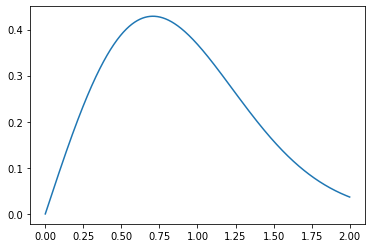

In [42]:
%matplotlib inline

# The .plot() is a versatile function, and will take an arbitrary number of arguments. For example, to plot x versus y.
plt.plot(X, Y)